#### DATA COLLECTION

Collection of 'X' media data using Twitter API 

In [1]:
import tweepy
import numpy as np
import pandas as pd
import time

In [2]:
import pandas as pd

In [ ]:
BEARER_TOKEN="AAAAAAAAAAAAAAAAAAAAAD5B0gEAAAAA9S3gQGwKhX0NfJ721u66KsMPMBw%3DGOfKO7bjQytwltENvlASK7KNKJ7VsL06xsWb07OdM4Y3TamA5E"

In [4]:
try:
    client = tweepy.Client(bearer_token=BEARER_TOKEN)
    print("Authentication successful")

except tweepy.errors.TweepyException as e:
    print(f"Authentication failed: {e}")
    exit()

Authentication successful


In [5]:
query = "(#technology OR #tech OR #ai OR #artificialintelligence OR #machinelearning OR #datascience OR #programming OR #entertainment OR #celebrity OR #popculture OR #music OR #tvshow OR #gossip OR #trending OR #business OR #sports OR #finance) lang:en -is:retweet"
tweet_count = 100 

In [6]:
try:
    tweets = client.search_recent_tweets(
        query=query,
        max_results=tweet_count,
        tweet_fields=["created_at", "author_id", "public_metrics"],
        user_fields=["username", "public_metrics"],  
        expansions=["author_id"]  
    )

    data = []
    users = {user["id"]: user for user in tweets.includes["users"]} if tweets.includes else {}

    if tweets.data:
        for tweet in tweets.data:
            user = users.get(tweet.author_id, {})
            data.append([
                tweet.id,
                tweet.text,
                tweet.created_at,
                tweet.author_id,
                tweet.public_metrics["like_count"],  
                tweet.public_metrics["retweet_count"], 
                tweet.public_metrics["reply_count"],  
                tweet.public_metrics["quote_count"],  
                user.get("username", "N/A"),  
                user.get("public_metrics", {}).get("followers_count", "N/A"), 
                user.get("public_metrics", {}).get("following_count", "N/A"),  
                user.get("public_metrics", {}).get("tweet_count", "N/A") 
            ])

       
        df = pd.DataFrame(data, columns=[
            "Tweet_ID", "Text", "Timestamp", "Author_ID", "Likes", "Retweets", "Replies", "Quotes",
            "Username", "Followers", "Following", "Total_Tweets"
        ])
        df.to_csv("twitter_data.csv", index=False)
        print("Data collection complete! Check twitter_data.csv")

    else:
        print("No tweets found for the given query")

except tweepy.errors.TweepyException as e:
    print(f"Error: {e}")
    time.sleep(15) 

Error: 401 Unauthorized
Unauthorized


Merging two datasets into a single .CSV file

In [7]:
# df1 = pd.read_csv("C:/Users/Bhargavi/Desktop/twitter_data.csv")
# df2 = pd.read_csv("C:/Users/Bhargavi/Desktop/twitter_data2.csv")

In [8]:
# merged_df = pd.concat([df1, df2]).drop_duplicates()
# merged_df.to_csv("cleaned_twitter_data.csv", index=False)
# print(f"Duplicate rows found: {merged_df.duplicated().sum()}") 
# print(f"Final cleaned dataset size: {len(merged_df)}")

In [1]:
import pyspark
import re
import nltk
from pyspark.sql.functions import col, lower, regexp_replace, udf, explode, split, size
from pyspark.sql.types import StringType, ArrayType, IntegerType
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bhargavi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bhargavi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Start Spark Session and load the dataset

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder \
    .appName("TwitterDataPreprocessing") \
    .getOrCreate()

In [4]:
tweets_df = spark.read.csv("C:/Users/Bhargavi/Desktop/twitter_data2.csv", header=True, inferSchema=True, multiLine=True)
tweets_df.show(5, truncate=False)

+----------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------+---------------------+-----+--------+-------+------+---------------+---------+---------+------------+
|Tweet_ID              |Text                                                                                                                                                                |Timestamp                |Author_ID            |Likes|Retweets|Replies|Quotes|Username       |Followers|Following|Total_Tweets|
+----------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------+---------------------+-----+--------+-------+------+---------------+---------+---------+------------+
|1.9110482860577551e+18|🥯 Throw your Bagel out th

In [5]:
tweets_df.columns

['Tweet_ID',
 'Text',
 'Timestamp',
 'Author_ID',
 'Likes',
 'Retweets',
 'Replies',
 'Quotes',
 'Username',
 'Followers',
 'Following',
 'Total_Tweets']

Cleaning and preprocessing data

In [6]:
def clean_tweet(text):
    if text is None:
        return ""
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  
    text = re.sub(r"\@\w+|\#", "", text)                                    
    text = re.sub(r"[^\w\s]", "", text)                                      
    text = re.sub(r"\d+", "", text)                                           
    text = text.encode('ascii', 'ignore').decode('ascii')                   
    text = text.lower().strip()                                             
    text = re.sub(r'\s+', ' ', text)                                       
    return text
clean_tweet_udf = udf(clean_tweet, StringType())

In [7]:
tweets_df = tweets_df.withColumn("clean_text", clean_tweet_udf(col("Text")))
tweets_df.show(5, truncate=False)

+----------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------+---------------------+-----+--------+-------+------+---------------+---------+---------+------------+--------------------------------------------------------------------------------------------------------------------------------+
|Tweet_ID              |Text                                                                                                                                                                |Timestamp                |Author_ID            |Likes|Retweets|Replies|Quotes|Username       |Followers|Following|Total_Tweets|clean_text                                                                                                                      |
+----------------------+------------------------------------------------------------------------------------

In [8]:
stop_words = set(stopwords.words("english"))

In [9]:
def remove_stopwords(text):
    words = text.split()
    return " ".join([word for word in words if word not in stop_words])
    
remove_stopwords_udf = udf(remove_stopwords, StringType())

In [10]:

tweets_df = tweets_df.withColumn("clean_text", remove_stopwords_udf(col("clean_text")))

In [11]:
tweets_df.show(5, truncate=False)

+----------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------+---------------------+-----+--------+-------+------+---------------+---------+---------+------------+---------------------------------------------------------------------------------------------------------------------------+
|Tweet_ID              |Text                                                                                                                                                                |Timestamp                |Author_ID            |Likes|Retweets|Replies|Quotes|Username       |Followers|Following|Total_Tweets|clean_text                                                                                                                 |
+----------------------+----------------------------------------------------------------------------------------------

In [12]:
tweets_df.show(5)

+--------------------+--------------------+--------------------+--------------------+-----+--------+-------+------+---------------+---------+---------+------------+--------------------+
|            Tweet_ID|                Text|           Timestamp|           Author_ID|Likes|Retweets|Replies|Quotes|       Username|Followers|Following|Total_Tweets|          clean_text|
+--------------------+--------------------+--------------------+--------------------+-----+--------+-------+------+---------------+---------+---------+------------+--------------------+
|1.911048286057755...|🥯 Throw your Bag...|2025-04-12 13:26:...|7.929148288977715...|    0|       0|      0|     0|MichaelRayRound|     2733|     2615|        1824|throw bagel windo...|
|1.911048281263595...|DePIN isn’t code—...|2025-04-12 13:26:...|1.874024930024575...|    0|       0|      0|     0|     Ajiboye010|        2|      221|         204|depin isnt codeit...|
|1.911048263639114...|Who carries out y...|2025-04-12 13:26:...|       

In [13]:
# !pip uninstall numpy scipy nltk -y
# !pip install numpy scipy nltk

Spark Data Processing

(a) Trend Analysis

In [14]:
tweets_df = tweets_df.withColumn("hashtags", 
    split(col("Text"), " "))

In [15]:
tweets_df = tweets_df.withColumn("hashtags", 
    split(col("Text"), " "))

In [16]:
hashtag_counts = tweets_df.groupBy("hashtags").count().orderBy("count", ascending=False)
hashtag_counts.show(10, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|hashtags                                                                                                                                                                                                                                                                                                          |count|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|NULL                                                  

User Engagement Metrics

In [17]:
tweets_df = tweets_df.withColumn("total_engagement", col("Likes") + col("Retweets") + col("Replies") + col("Quotes"))
top_tweets = tweets_df.orderBy(col("total_engagement").desc()).select("Tweet_ID", "Text", "total_engagement")

top_tweets.show(10, truncate=False)


+-------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+
|Tweet_ID                             |Text                                                                                                                                                                                                                                                  |total_engagement      |
+-------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+
|1.9109359573663544e+18               |"1/3: ""Title+Thread: Google Jo

In [18]:
from pyspark.sql.functions import col, sum

user_engagement = tweets_df.groupBy("Author_ID").agg(
    sum(col("Likes").cast("int")).alias("total_likes"),
    sum(col("Retweets").cast("int")).alias("total_retweets"),
    sum(col("Replies").cast("int")).alias("total_replies"),
    sum(col("Quotes").cast("int")).alias("total_quotes")
)


user_engagement = user_engagement.withColumn("total_engagement", 
                                             col("total_likes") + col("total_retweets") + 
                                             col("total_replies") + col("total_quotes"))


top_users = user_engagement.orderBy(col("total_engagement").desc()).limit(10)
top_users.show(10, truncate=False)


+-------------------------+-----------+--------------+-------------+------------+----------------+
|Author_ID                |total_likes|total_retweets|total_replies|total_quotes|total_engagement|
+-------------------------+-----------+--------------+-------------+------------+----------------+
|2025-04-12 06:39:28+00:00|1337903059 |1             |0            |0           |1337903060      |
|2025-04-04 12:35:40+00:00|550477275  |0             |0            |0           |550477275       |
|2025-04-04 09:56:23+00:00|39460770   |0             |0            |0           |39460770        |
|2025-04-12 06:58:08+00:00|33837930   |0             |0            |0           |33837930        |
|1.3246031675737416e+18   |5          |5             |75           |0           |85              |
|1.172180266003026e+18    |50         |5             |4            |0           |59              |
|1.7412765514490266e+18   |4          |4             |43           |5           |56              |
|8.1075622

Network Analysis

In [19]:
tweets_df.columns

['Tweet_ID',
 'Text',
 'Timestamp',
 'Author_ID',
 'Likes',
 'Retweets',
 'Replies',
 'Quotes',
 'Username',
 'Followers',
 'Following',
 'Total_Tweets',
 'clean_text',
 'hashtags',
 'total_engagement']

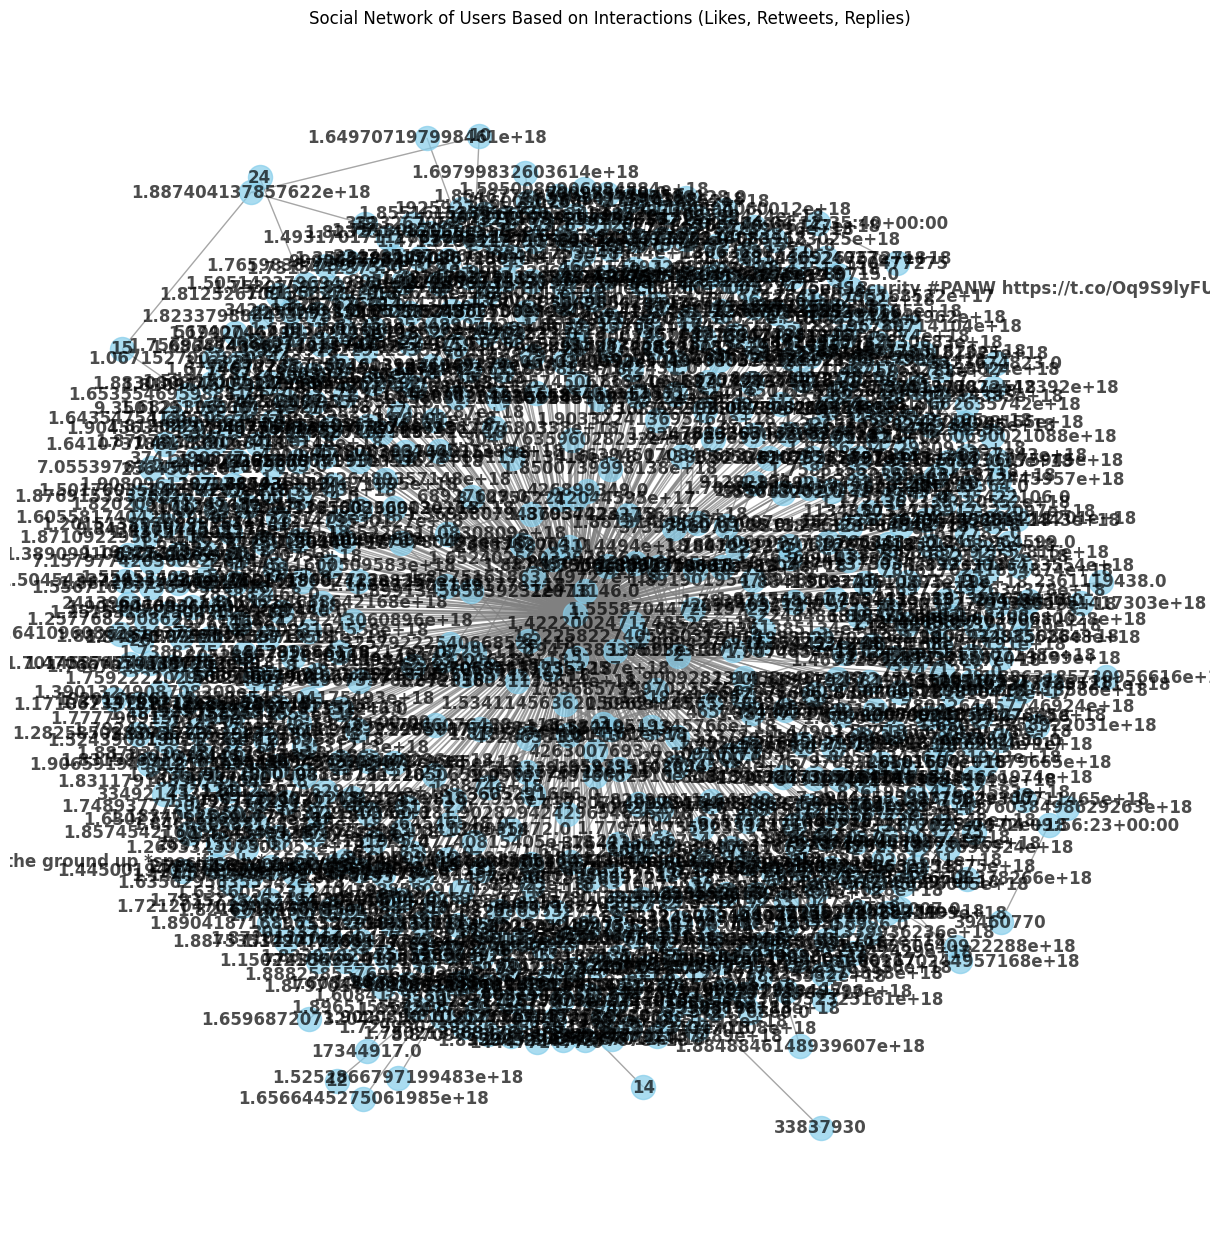

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

G = nx.Graph()
tweets_df = tweets_df.withColumn("Retweets", F.col("Retweets").cast("int"))
tweets_df = tweets_df.withColumn("Replies", F.col("Replies").cast("int"))
tweets_df = tweets_df.withColumn("Likes", F.col("Likes").cast("int"))

tweets_df_filtered = tweets_df.filter((tweets_df['Retweets'] > 0) | (tweets_df['Replies'] > 0) | (tweets_df['Likes'] > 0))

edges = []

for row in tweets_df_filtered.collect():
    retweets = row['Retweets'] if row['Retweets'] is not None else 0
    replies = row['Replies'] if row['Replies'] is not None else 0
    likes = row['Likes'] if row['Likes'] is not None else 0
    
    if retweets > 0:
        edges.append((row['Author_ID'], row['Retweets']))  
    if replies > 0:
        edges.append((row['Author_ID'], row['Replies'])) 
    if likes > 0:
        edges.append((row['Author_ID'], row['Likes']))  

G.add_edges_from(edges)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15, iterations=20)
nx.draw(G, pos, with_labels=True, node_size=300, font_size=12, node_color='skyblue', edge_color='gray', alpha=0.7, font_weight='bold')
plt.title('Social Network of Users Based on Interactions (Likes, Retweets, Replies)')
plt.show()


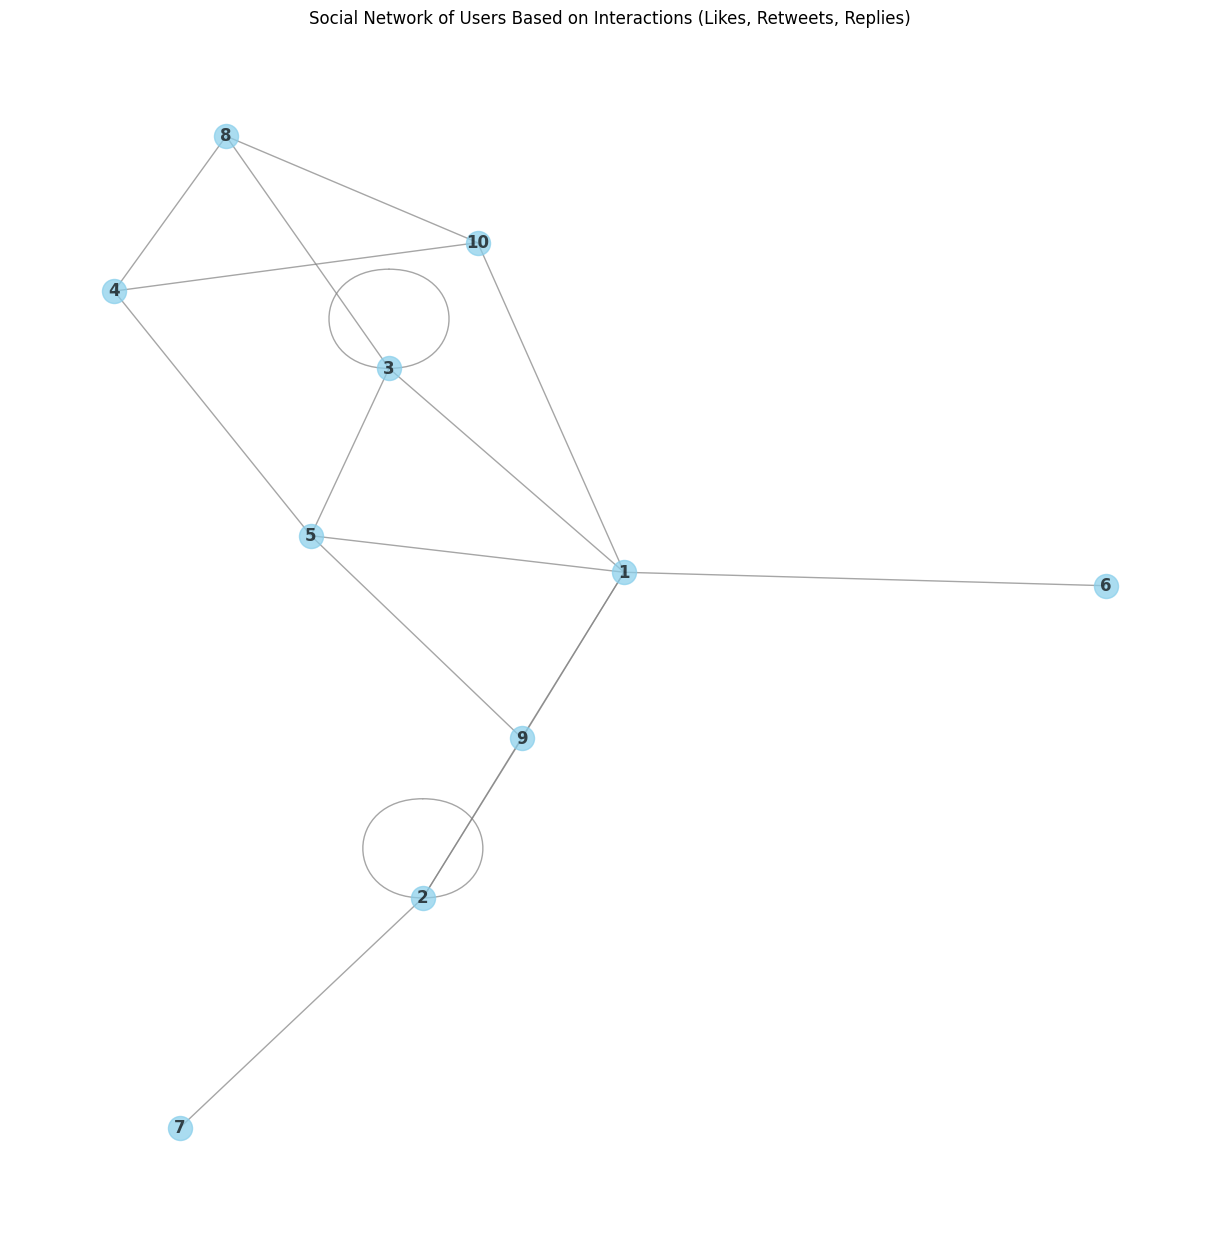

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

data = [
    {'Author_ID': 1, 'Retweets': 2, 'Replies': 0, 'Likes': 5},
    {'Author_ID': 2, 'Retweets': 1, 'Replies': 2, 'Likes': 0},
    {'Author_ID': 3, 'Retweets': 0, 'Replies': 3, 'Likes': 1},
    {'Author_ID': 4, 'Retweets': 0, 'Replies': 0, 'Likes': 10},
    {'Author_ID': 5, 'Retweets': 3, 'Replies': 0, 'Likes': 4},
    {'Author_ID': 6, 'Retweets': 0, 'Replies': 1, 'Likes': 0},
    {'Author_ID': 7, 'Retweets': 0, 'Replies': 0, 'Likes': 2},
    {'Author_ID': 8, 'Retweets': 4, 'Replies': 0, 'Likes': 3},
    {'Author_ID': 9, 'Retweets': 2, 'Replies': 1, 'Likes': 5},
    {'Author_ID': 10, 'Retweets': 1, 'Replies': 0, 'Likes': 8}
]

G = nx.Graph()
edges = []

for row in data:
    author_id = row['Author_ID']
    retweets = row['Retweets']
    replies = row['Replies']
    likes = row['Likes']
    
    if retweets > 0:
        edges.append((author_id, retweets))
    if replies > 0:
        edges.append((author_id, replies)) 
    if likes > 0:
        edges.append((author_id, likes)) 

G.add_edges_from(edges)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15, iterations=20)
nx.draw(G, pos, with_labels=True, node_size=300, font_size=12, node_color='skyblue', edge_color='gray', alpha=0.7, font_weight='bold')
plt.title('Social Network of Users Based on Interactions (Likes, Retweets, Replies)')
plt.show()


Number of edges: 17
Top 10 Influencers by Degree Centrality:
User: 1, Centrality: 0.6666666666666666
User: 2, Centrality: 0.5555555555555556
User: 3, Centrality: 0.5555555555555556
User: 5, Centrality: 0.4444444444444444
User: 4, Centrality: 0.3333333333333333
User: 10, Centrality: 0.3333333333333333
User: 8, Centrality: 0.3333333333333333
User: 9, Centrality: 0.3333333333333333
User: 6, Centrality: 0.1111111111111111
User: 7, Centrality: 0.1111111111111111


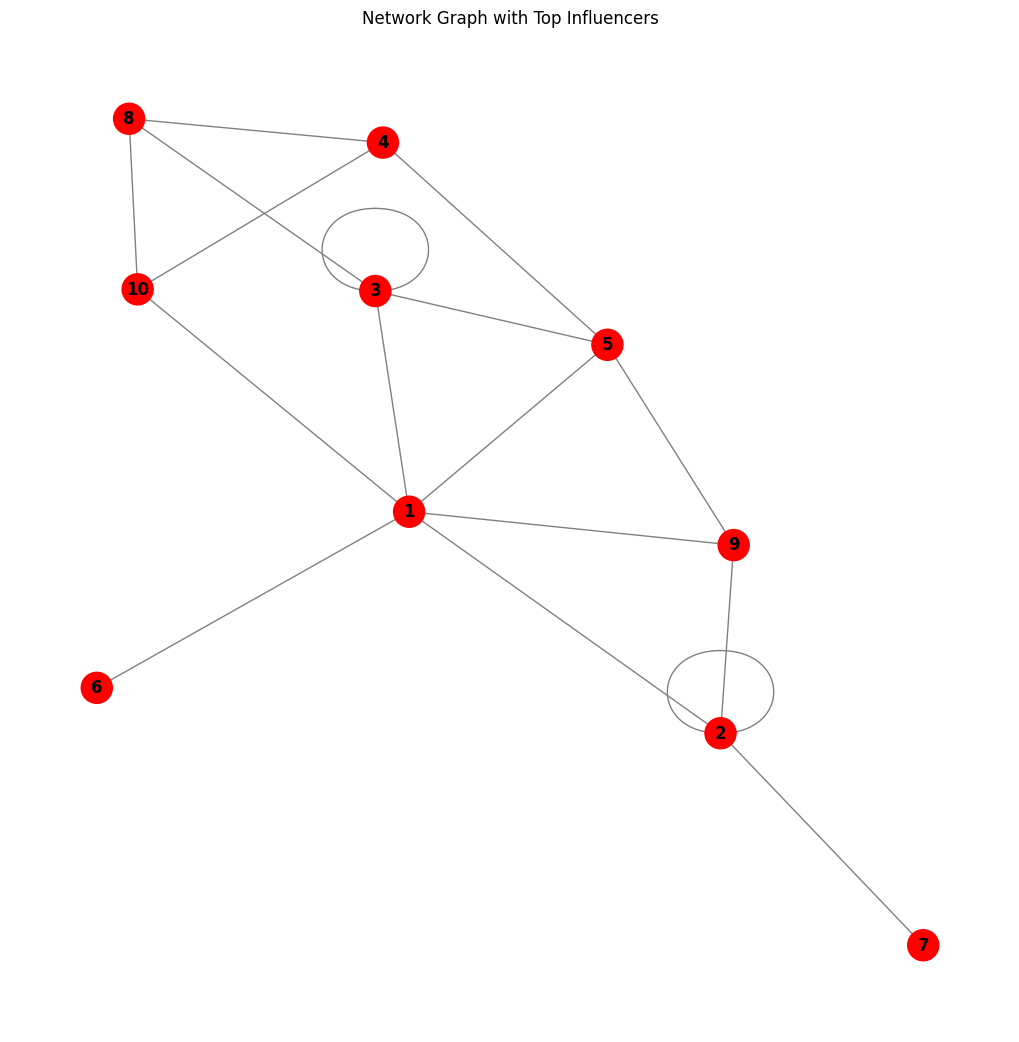

In [22]:
G = nx.Graph()
edges = []

for row in data:
    author_id = row['Author_ID']
    retweets = row['Retweets']
    replies = row['Replies']
    likes = row['Likes']
    
    if retweets > 0:
        edges.append((author_id, retweets)) 
    if replies > 0:
        edges.append((author_id, replies)) 
    if likes > 0:
        edges.append((author_id, likes)) 

G.add_edges_from(edges)

print(f"Number of edges: {len(G.edges)}")
degree_centrality = nx.degree_centrality(G)
top_influencers = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Influencers by Degree Centrality:")
for user, centrality in top_influencers:
    print(f"User: {user}, Centrality: {centrality}")

top_influencer_ids = [user for user, _ in top_influencers]

plt.figure(figsize=(10, 10))
node_color = ['red' if node in top_influencer_ids else 'lightblue' for node in G.nodes()]
nx.draw(G, with_labels=True, node_size=500, font_size=12, node_color=node_color, edge_color='gray', font_weight='bold')
plt.title('Network Graph with Top Influencers')
plt.show()

Detected Communities:
Community 1: {1, 3, 4, 5, 6, 8, 9, 10}
Community 2: {2, 7}


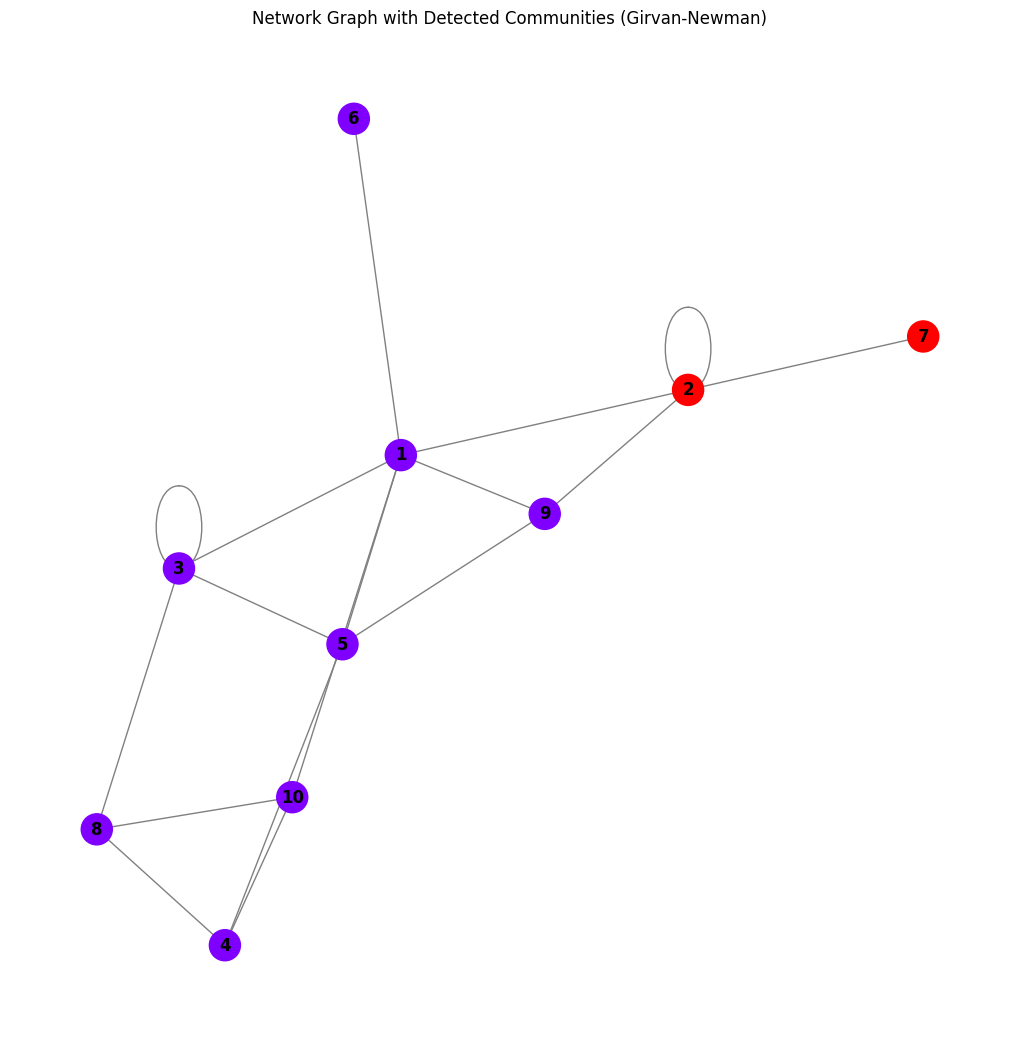

In [23]:
from networkx.algorithms.community import girvan_newman

G = nx.Graph()
edges = []

for row in data:
    author_id = row['Author_ID']
    retweets = row['Retweets']
    replies = row['Replies']
    likes = row['Likes']
    
    if retweets > 0:
        edges.append((author_id, retweets))  
    if replies > 0:
        edges.append((author_id, replies)) 
    if likes > 0:
        edges.append((author_id, likes))  

G.add_edges_from(edges)

comp = girvan_newman(G)
top_level_communities = next(comp)
print("Detected Communities:")
for i, community in enumerate(top_level_communities):
    print(f"Community {i + 1}: {community}")


plt.figure(figsize=(10, 10))
community_color_map = []
for node in G.nodes():
    for i, community in enumerate(top_level_communities):
        if node in community:
            community_color_map.append(i)  
            break

nx.draw(G, with_labels=True, node_size=500, font_size=12, node_color=community_color_map, cmap=plt.cm.rainbow, edge_color='gray', font_weight='bold')
plt.title('Network Graph with Detected Communities (Girvan-Newman)')
plt.show()


In [24]:
tweets_df.printSchema()

root
 |-- Tweet_ID: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Author_ID: string (nullable = true)
 |-- Likes: integer (nullable = true)
 |-- Retweets: integer (nullable = true)
 |-- Replies: integer (nullable = true)
 |-- Quotes: string (nullable = true)
 |-- Username: string (nullable = true)
 |-- Followers: string (nullable = true)
 |-- Following: string (nullable = true)
 |-- Total_Tweets: string (nullable = true)
 |-- clean_text: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- total_engagement: double (nullable = true)



Geospatial Analysis

In [25]:
from pyspark.sql.functions import explode, col, udf
from pyspark.sql.types import StringType, StructType, StructField, DoubleType, StructType

df_hashtags = tweets_df.withColumn("hashtag", explode(col("hashtags")))

hashtag_location_map = {
    "#NYC": ("New York City", (40.7128, -74.0060)),
    "#LosAngeles": ("Los Angeles", (34.0522, -118.2437)),
    "#SanFrancisco": ("San Francisco", (37.7749, -122.4194)),
    "#Chicago": ("Chicago", (41.8781, -87.6298)),
    "#Houston": ("Houston", (29.7604, -95.3698)),
    "#Miami": ("Miami", (25.7617, -80.1918)),
    "#Boston": ("Boston", (42.3601, -71.0589)),
    "#Seattle": ("Seattle", (47.6062, -122.3321)),
    "#Dallas": ("Dallas", (32.7767, -96.7970)),
    "#Atlanta": ("Atlanta", (33.7490, -84.3880)),
    "#London": ("London", (51.5074, -0.1278)),
    "#Manchester": ("Manchester", (53.4808, -2.2426)),
    "#Birmingham": ("Birmingham", (52.4862, -1.8904)),
    "#Delhi": ("Delhi", (28.6139, 77.2090)),
    "#Mumbai": ("Mumbai", (19.0760, 72.8777)),
    "#Bombay": ("Mumbai", (19.0760, 72.8777)), 
    "#Hyderabad": ("Hyderabad", (17.3850, 78.4867)),
    "#Bangalore": ("Bangalore", (12.9716, 77.5946)),
    "#Bengaluru": ("Bangalore", (12.9716, 77.5946)),  
    "#Mangalore": ("Mangalore", (12.9141, 74.8560)),
    "#Chennai": ("Chennai", (13.0827, 80.2707)),
    "#Pune": ("Pune", (18.5204, 73.8567)),
    "#Kolkata": ("Kolkata", (22.5726, 88.3639)),
    "#Ahmedabad": ("Ahmedabad", (23.0225, 72.5714)),
    "#Vizag": ("Visakhapatnam", (17.6868, 83.2185)),
    "#Jaipur": ("Jaipur", (26.9124, 75.7873)),
    "#Lucknow": ("Lucknow", (26.8467, 80.9462)),
    "#Chandigarh": ("Chandigarh", (30.7333, 76.7794)),
    "#Coimbatore": ("Coimbatore", (11.0168, 76.9558)),
    "#Paris": ("Paris", (48.8566, 2.3522)),
    "#Berlin": ("Berlin", (52.5200, 13.4050)),
    "#Rome": ("Rome", (41.9028, 12.4964)),
    "#Madrid": ("Madrid", (40.4168, -3.7038)),
    "#Barcelona": ("Barcelona", (41.3784, 2.1925)),
    "#Zurich": ("Zurich", (47.3769, 8.5417)),
    "#Amsterdam": ("Amsterdam", (52.3676, 4.9041)),
    "#Athens": ("Athens", (37.9838, 23.7275)),
    "#Helsinki": ("Helsinki", (60.1695, 24.9354)),
    "#Tokyo": ("Tokyo", (35.6762, 139.6503)),
    "#Seoul": ("Seoul", (37.5665, 126.9780)),
    "#Singapore": ("Singapore", (1.3521, 103.8198)),
    "#Bangkok": ("Bangkok", (13.7563, 100.5018)),
    "#KualaLumpur": ("Kuala Lumpur", (3.1390, 101.6869)),
    "#Jakarta": ("Jakarta", (-6.2088, 106.8456)),
    "#Dubai": ("Dubai", (25.276987, 55.296249)),
    "#Istanbul": ("Istanbul", (41.0082, 28.9784)),
    "#Cairo": ("Cairo", (30.0444, 31.2357)),
    "#CapeTown": ("Cape Town", (-33.9249, 18.4241)),
    "#Lagos": ("Lagos", (6.5244, 3.3792)),
    "#BuenosAires": ("Buenos Aires", (-34.6037, -58.3816)),
    "#Rio": ("Rio de Janeiro", (-22.9068, -43.1729)),
    "#SaoPaulo": ("Sao Paulo", (-23.5505, -46.6333)),
    "#MexicoCity": ("Mexico City", (19.4326, -99.1332)),
    "#Toronto": ("Toronto", (43.6532, -79.3832)),
    "#Vancouver": ("Vancouver", (49.2827, -123.1207)),
    "#Moscow": ("Moscow", (55.7558, 37.6173)),
    "#India": ("India", (20.5937, 78.9629)),
    "#USA": ("USA", (37.0902, -95.7129)),
    "#UK": ("United Kingdom", (55.3781, -3.4360)),
    "#Europe": ("Europe", (54.5260, 15.2551)),
    "#Asia": ("Asia", (34.0479, 100.6197)),
}

def map_hashtag_to_city(hashtag):
    hashtag = hashtag.strip()
    if hashtag in hashtag_location_map:
        return hashtag_location_map[hashtag][0]  
    else:
        return None

map_udf = udf(map_hashtag_to_city, StringType())

df_city = df_hashtags.withColumn("City", map_udf(col("hashtag")))
df_city = df_city.filter(col("City").isNotNull())
city_trend = df_city.groupBy("City").count().orderBy(col("count").desc())
city_trend.show(truncate=False)


+--------------+-----+
|City          |count|
+--------------+-----+
|USA           |23   |
|India         |19   |
|United Kingdom|10   |
|Asia          |8    |
|London        |7    |
|Europe        |5    |
|Mumbai        |5    |
|Dubai         |4    |
|Birmingham    |3    |
|Manchester    |2    |
|Los Angeles   |2    |
|Pune          |2    |
|Bangalore     |1    |
|Chennai       |1    |
|Tokyo         |1    |
|Vancouver     |1    |
|Delhi         |1    |
|New York City |1    |
|Bangkok       |1    |
|Hyderabad     |1    |
+--------------+-----+
only showing top 20 rows



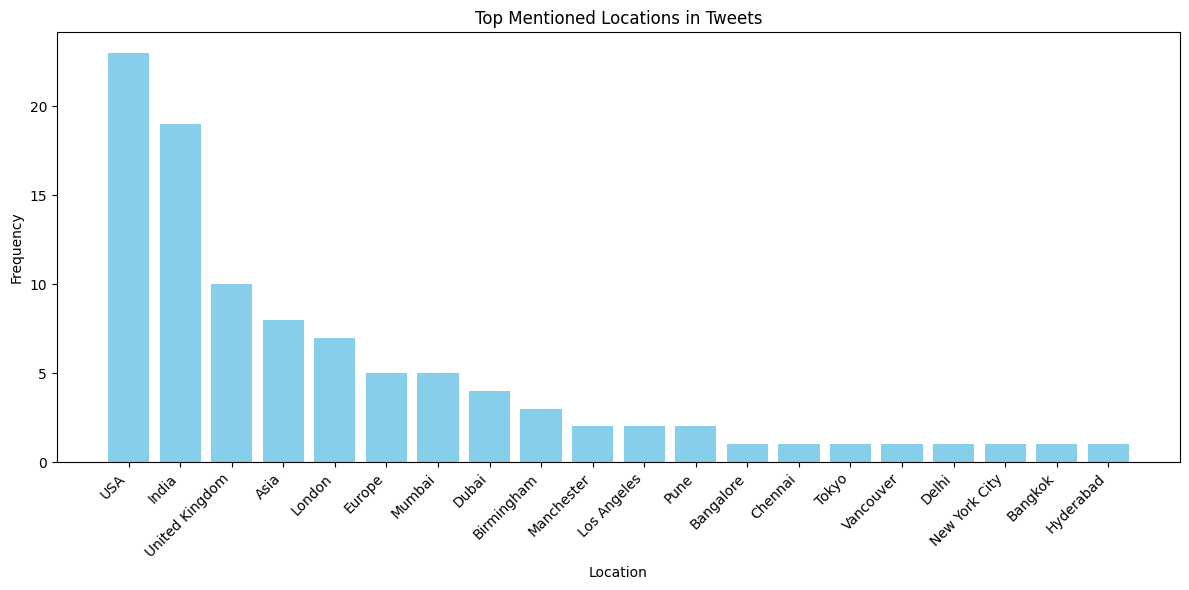

In [26]:
location_counts = city_trend.limit(20).collect()  
locations = [row['City'] for row in location_counts]
counts = [row['count'] for row in location_counts]

plt.figure(figsize=(12,6))
plt.bar(locations, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Top Mentioned Locations in Tweets')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [27]:
pandas_df = tweets_df.toPandas()
pandas_df.to_csv(r"C:\Users\Bhargavi\Desktop\processed_tweets.csv", index=False, encoding='utf-8')

In [28]:
from pyspark.streaming import StreamingContext

In [ ]:
sc = spark.sparkContext
ssc = StreamingContext(sc, 5)
lines = ssc.socketTextStream("localhost", 9999)
words = lines.flatMap(lambda line: line.lower().split())
hashtags = words.filter(lambda word: word.startswith("#"))

def print_hashtags(rdd):
    hashtags = rdd.collect()  
    if hashtags:
        for hashtag in hashtags:
            print(f"Found hashtag: {hashtag}")

hashtags.foreachRDD(print_hashtags)


ssc.start()
ssc.awaitTermination()

c:\Users\Bhargavi\.conda\envs\project\Lib\site-packages\pyspark\streaming\context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(


Found hashtag: #bagel
Found hashtag: #throw
Found hashtag: #youdontcare
Found hashtag: #intheair
Found hashtag: #out
Found hashtag: #window
Found hashtag: #michael
Found hashtag: #vlog
Found hashtag: #trending
Found hashtag: #viral
Found hashtag: #fyp
Found hashtag: #shorts
Found hashtag: #azen
Found hashtag: #ai
Found hashtag: #forklift
Found hashtag: #maintenance?
Found hashtag: #business
Found hashtag: #regulations
Found hashtag: #repairs
Found hashtag: #healthandsafety
Found hashtag: #google
Found hashtag: #ai
Found hashtag: #innovation
Found hashtag: #ai
Found hashtag: #web3
Found hashtag: #creatoreconomy
Found hashtag: #hanumanjanmotsav
Found hashtag: #topcodder
Found hashtag: #jaihanuman
Found hashtag: #hanumanjayanti
Found hashtag: #festivalwishes
Found hashtag: #spiritualvibes
Found hashtag: #bajrangbali
Found hashtag: #ai
Found hashtag: #azen
Found hashtag: #ai
Found hashtag: #azen
Found hashtag: #ai
Found hashtag: #seo
Found hashtag: #oylu
Found hashtag: #business
Found hash